:warning:**IMPORTANT NOTICE**:warning:\
*Since the initial parameterisation and gradient descent optimisation are stochastic processes, the training of a neural network is not fully reproducible.*

*Therefore, it is not recommended to re-run this script as it will overwrite the original calibration of the neural network used in the work presented here.
The purpose of this script is solely to document the training procedure and can be copied as a template to fit other new neural networks.*

*To experiment with the models calibrated here, they can be loaded from the `saved_models` directory.*

# Train neural network on simulated data from **ds62** with **White et al. (2014)** biotite solution model

Predict pressure and temperature from biotite composition.\
The data are simulated biotite composition - pressure - temperature triples. These data were generated using phase equilibrium modelling (Theriak-Domino).

Trained ANN is used as prior in transfer learning with natural data.

### Hyperparameter
These hyperparameters were determined by tests conducted in "hyperparameter_testing.ipynb".\
All tests were conducted on the simulated data of ds62-White2014.

**Performance metrics:**
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)
- Root Mean Square Error (RMSE)
    - RMSE inverse transformed for pressure and temperature

**Last layer activation function:**
- Linear --> Regression problem

**Loss function:**
- Mean Squared Error (MSE)

**Optimizer:**
- Adam with inverse time decay learning rate scheduler

**Batch size:**
- 500

**Architecture:**
- 4 hidden layers with 64 neurons each

**Activation function:**
- ReLU

**Regularization:**
- Small network capacity proved to be sufficient for this problem. Therefore, no regularization was used.

### Goal
Best possible performance on the validation set.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import h5py

from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Normalization, BatchNormalization, LayerNormalization, Dropout
from keras.losses import MeanSquaredError
from keras.optimizers import Adam, schedules
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from keras.callbacks import CSVLogger, EarlyStopping
from sklearn.model_selection import train_test_split

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_P, RMSE_denormalised_T
from ml_tb.plot import _smooth

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_13508\3732669427.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Import data, pre-procesing and train/test split

For bioitte composition only extract elements which are modelled to be present in biotite by ds62.\
Element-idx from hdf5 file:
```python
(0, 'O') (1, 'SI') (2, 'TI') (3, 'AL') (4, 'FE') (5, 'MG') (6, 'MN') (7, 'CA') (8, 'NA') (9, 'K') (10, 'H')
```
Only extract: Si, Ti, Al, Fe, Mg, Mn.\
K would be in modelled biotite, but is fixed at 1.0.

Validation set is **10%** of the training set. Approx. 6000 samples.

In [2]:
# load hdf file
file = Path("10022024_Biotite_ds62.hdf5")
with h5py.File(file, "r") as hdf_file:
    PT = np.array(hdf_file["PT"])
    full_biotite_composition = np.array(hdf_file["mineral_composition"])
    element_idx = hdf_file["mineral_composition"].attrs["element idx [apfu]"]

print(*enumerate(element_idx))

biotite_composition = full_biotite_composition[:,[1, 2, 3, 4, 6, 5]]
pt = PT

biotite_composition_train, biotite_composition_val, pt_train, pt_val = train_test_split(biotite_composition, pt, test_size=0.10, shuffle=True)

# normalise biotite composition & min-max scale PT
normalisation_biotite_composition = Normalization(axis=-1)
normalisation_biotite_composition.adapt(biotite_composition_train)

print(normalisation_biotite_composition.mean.numpy())
print(np.sqrt(normalisation_biotite_composition.variance.numpy()))

scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)
pt_train_norm = scaling_pt(pt_train)
pt_val_norm = scaling_pt(pt_val)

(0, 'O') (1, 'SI') (2, 'TI') (3, 'AL') (4, 'FE') (5, 'MG') (6, 'MN') (7, 'CA') (8, 'NA') (9, 'K') (10, 'H')

[[2.677453   0.11015208 1.5238823  1.5181226  0.01042802 1.1599641 ]]
[[0.09304704 0.04673197 0.16558857 0.31455868 0.0093776  0.2741287 ]]


## Set-up model & training parameters

Use callbacks to save the best model and to stop training if the validation loss does not decrease for 10 epochs.

### Custom metrics

Define a custom metric to evaluate the RMSE of temperature and pressure in meaningful units.\
The RMSE is calculated on the inverse transformed data and therefore has the units of the original data ([bar]/[&deg;C]).

In [3]:
def RMSE_P(y_true, y_pred):
    return RMSE_denormalised_P(y_true, y_pred, inv_scaling_pt)


def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_T(y_true, y_pred, inv_scaling_pt)

In [4]:
BATCH_SIZE = 500
STEPS_PER_EPOCH = len(biotite_composition_train) // BATCH_SIZE
MAX_EPOCHS = 5000

lr_schedule = schedules.InverseTimeDecay(0.001, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)
OPT = Adam(lr_schedule)

LOSS = MeanSquaredError()
METRICS = [MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError(), RMSE_P, RMSE_T]

CALLBACKS = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True), CSVLogger("model_ds62White2014.log", append=False)]

In [5]:
model = Sequential()
model.add(normalisation_biotite_composition)
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(2))

model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                        

In [6]:
history = model.fit(biotite_composition_train, pt_train_norm,
                    batch_size=BATCH_SIZE, epochs=MAX_EPOCHS,
                    validation_data=[biotite_composition_val, pt_val_norm],
                    callbacks=CALLBACKS, verbose=True)

model.save(Path("saved_models", "model_ds62White2014"))

Epoch 1/5000


119/119 [==============================] - 6s 12ms/step - loss: 0.0414 - mean_absolute_error: 0.1430 - mean_absolute_percentage_error: 103060.5625 - root_mean_squared_error: 0.2036 - RMSE_P: 2025.5326 - RMSE_T: 59.0947 - val_loss: 0.0161 - val_mean_absolute_error: 0.0856 - val_mean_absolute_percentage_error: 56340.0391 - val_root_mean_squared_error: 0.1269 - val_RMSE_P: 1439.4348 - val_RMSE_T: 27.1681
Epoch 2/5000
119/119 [==============================] - 1s 7ms/step - loss: 0.0129 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 38059.2383 - root_mean_squared_error: 0.1137 - RMSE_P: 1311.6248 - RMSE_T: 21.6792 - val_loss: 0.0116 - val_mean_absolute_error: 0.0692 - val_mean_absolute_percentage_error: 11051.1914 - val_root_mean_squared_error: 0.1079 - val_RMSE_P: 1245.0305 - val_RMSE_T: 20.1457
Epoch 3/5000
119/119 [==============================] - 1s 5ms/step - loss: 0.0109 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 29333.2129 - root

INFO:tensorflow:Assets written to: saved_models\model_ds62White2014\assets


## Plotting of training curves

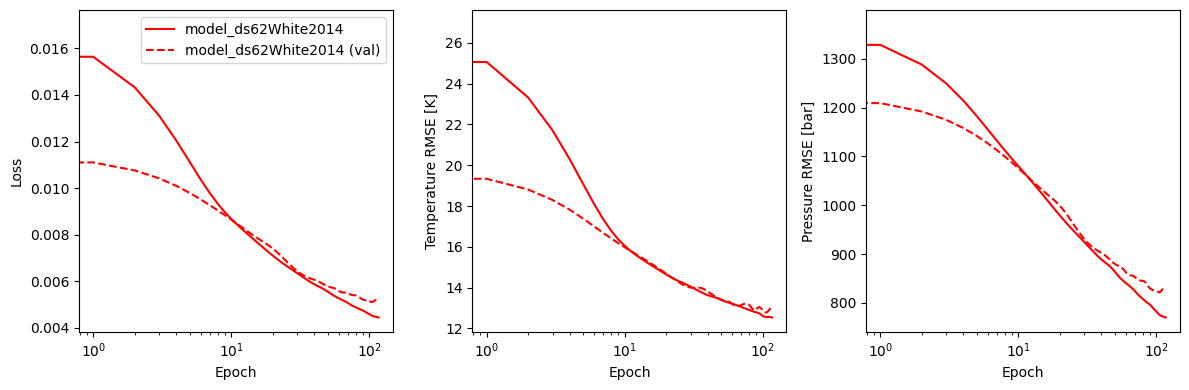

In [7]:
history = pd.read_csv(Path("model_ds62White2014.log"))

smooth_std = 10
color = "red"
label = "model_ds62White2014"

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(history['epoch'], _smooth(history['loss'], smooth_std), color=color, label=label)
axs[0].plot(history['epoch'], _smooth(history['val_loss'], smooth_std), color=color, linestyle='--', label=label + ' (val)')

axs[1].plot(history['epoch'], _smooth(history['RMSE_T'], smooth_std), color=color, label=label)
axs[1].plot(history['epoch'], _smooth(history['val_RMSE_T'], smooth_std), color=color, linestyle='--', label=label + ' (val)')

axs[2].plot(history['epoch'], _smooth(history['RMSE_P'], smooth_std), color=color, label=label)
axs[2].plot(history['epoch'], _smooth(history['val_RMSE_P'], smooth_std), color=color, linestyle='--', label=label + ' (val)')

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')


axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Temperature RMSE [K]')

axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Pressure RMSE [bar]')

axs[0].legend()

fig.tight_layout()

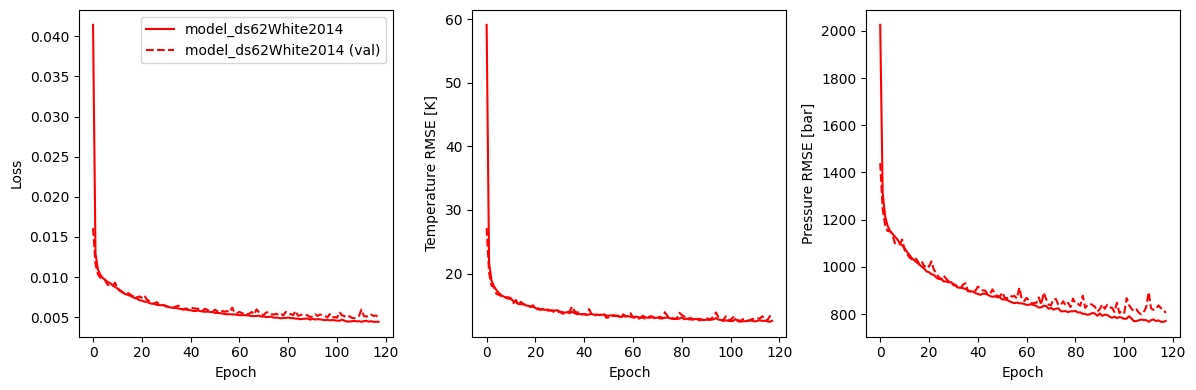

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(history['epoch'], history['loss'], color=color, label=label)
axs[0].plot(history['epoch'], history['val_loss'], color=color, linestyle='--', label=label + ' (val)')

axs[1].plot(history['epoch'], history['RMSE_T'], color=color, label=label)
axs[1].plot(history['epoch'], history['val_RMSE_T'], color=color, linestyle='--', label=label + ' (val)')

axs[2].plot(history['epoch'], history['RMSE_P'], color=color, label=label)
axs[2].plot(history['epoch'], history['val_RMSE_P'], color=color, linestyle='--', label=label + ' (val)')

# axs[0].set_xscale('log')
# axs[1].set_xscale('log')
# axs[2].set_xscale('log')


axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Temperature RMSE [K]')

axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Pressure RMSE [bar]')

axs[0].legend()

fig.tight_layout()